# 셸로우 포커스 만들기 
![](./imgs/01.png)

1. 배경이 있는 셀카를 촬영합니다. (배경과 사람의 거리가 약간 멀리 있으면 좋습니다.)
2. 시멘틱 세그멘테이션(Semantic segmentation)으로 피사체(사람)와 배경을 분리합니다.
3. 블러링(blurring) 기술로 배경을 흐리게 합니다.
4. 피사체를 배경의 원래 위치에 합성 합니다.

## library install

In [1]:
#! pip install opencv-python

## import library

In [1]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib # 웹에서 데이터를 다운로드 받을 때 사용

from matplotlib import pyplot as plt
import tensorflow as tf

## read imgs

In [2]:
img_path = os.getenv('HOME')+'/aiffel/AIFFEL_LSG/lms/01-EXPLORATION/E14-portrait/imgs/lsg-01.jpg' 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(640, 640, 3)


## segmentation : 사람 피사체 분리
- 이미지에서 픽셀 단위로 관심 객체를 추출하는 방법을 이미지 세그멘테이션(image segmentation)
- 모든 픽셀에 라벨(label)을 할당하고 같은 라벨은 "공통적인 특징"을 가진다고 가정
- 시멘틱 세그멘테이션(semantic segmentation)
- 인스턴스 세그멘테이션 ( 객체별)


## DeepLab
- https://blog.lunit.io/2018/07/02/deeplab-v3-encoder-decoder-with-atrous-separable-convolution-for-semantic-image-segmentation/

- DeepLab V1
    - atrous convolution
- DeepLab V2

- DeepLab V3

- DeepLab V4

## DeepLabModel

- demo https://github.com/tensorflow/models/blob/master/research/deeplab/deeplab_demo.ipynb

### class define

In [3]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image) # 전처리 메서드 호출.

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

### model import & model define

In [4]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = '~/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: ~/aiffel/human_segmentation/models
model loaded successfully!


### model run

In [5]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(640, 640, 3) (513, 513, 3) 15


### label정의

 - DeepLab은 PASCAL VOC의 라벨

In [29]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

15

In [ ]:
###

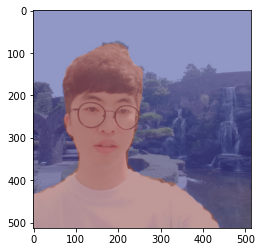

In [7]:
img_show = img_resized.copy() #  이미지 복사
#
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출

img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
                           
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

###  mask

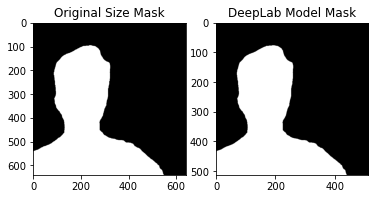

In [9]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

In [10]:
###

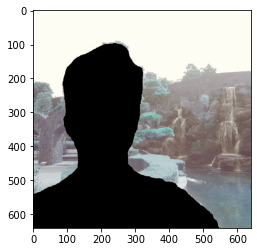

In [11]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

### blur

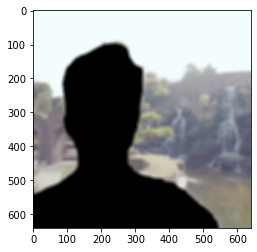

In [12]:
img_bg_blur = cv2.blur(img_bg, (13,13))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 흐린 배경과 원본 영상 합성

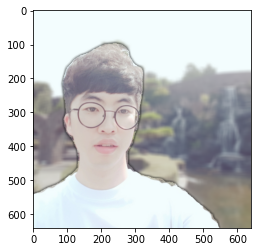

In [13]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 평가부분 

### 함수화
- model 까지 만들어있다고 가정.  (1.6.2) 부분까지 선언 필수
- 라벨 값 인덱스 찾아서 seg_map 정의
    

In [ ]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

In [34]:

def portraitFn(img_path, label_name):
    
    #label index 조회
    label_idx = LABEL_NAMES.index(label_name)
    
    # img read
    img_orig = cv2.imread(img_path)
    
    # mode run
    img_resized, seg_map = MODEL.run(img_orig)
    print (img_orig.shape, img_resized.shape, seg_map.max())
    
    
    
    img_show = img_resized.copy() #  이미지 복사
    seg_map = np.where(seg_map == label_idx, label_idx, 0) # 라벨대로

    img_mask = seg_map * (255/seg_map.max()) # 255 normalization
    img_mask = img_mask.astype(np.uint8)

    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
    plt.show()
    
    ##################################
    #mask
    img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

    ax = plt.subplot(1,2,1)
    plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
    ax.set_title('Original Size Mask')

    ax = plt.subplot(1,2,2)
    plt.imshow(img_mask, cmap=plt.cm.binary_r)
    ax.set_title('DeepLab Model Mask')

    plt.show()
    
    #######################################
    
    img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
    plt.imshow(img_bg)
    plt.show()
    
    
    #########################################
    #blur
    img_bg_blur = cv2.blur(img_bg, (13,13))
    plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
    plt.show()
    
    ########################################
    #blur배경과 원본 합성
    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()

### 내 사진 이미지 배경 분리

(640, 640, 3) (513, 513, 3) 15


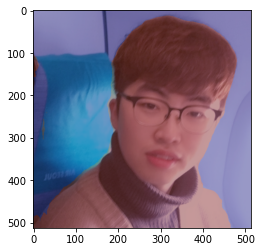

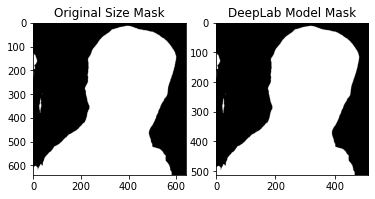

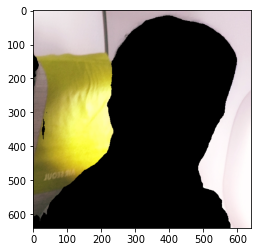

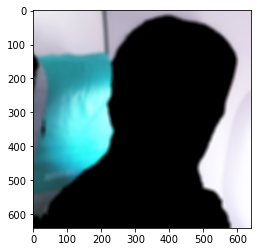

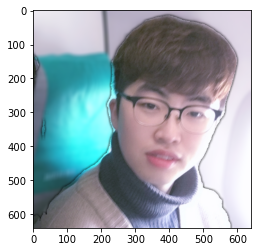

In [35]:
img_path = os.getenv('HOME')+'/aiffel/AIFFEL_LSG/lms/01-EXPLORATION/E14-portrait/imgs/lsg-02.jpg' 

portraitFn(img_path,"person")


### 야옹이 이미지 배경 분리

(332, 500, 3) (340, 513, 3) 8


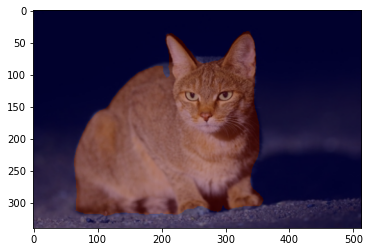

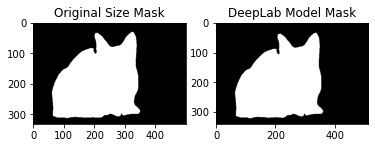

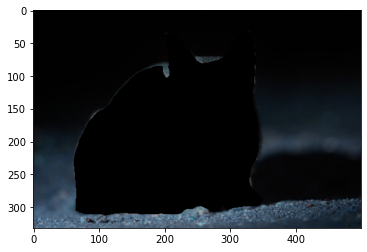

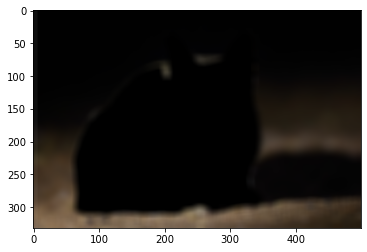

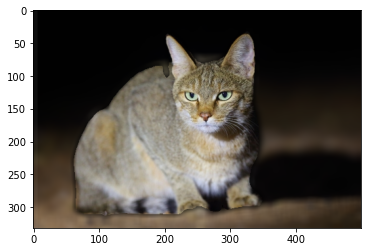

In [36]:
img_path = os.getenv('HOME')+'/aiffel/AIFFEL_LSG/lms/01-EXPLORATION/E14-portrait/imgs/cat3.jpg' 

portraitFn(img_path,"cat")

(358, 481, 3) (381, 513, 3) 16


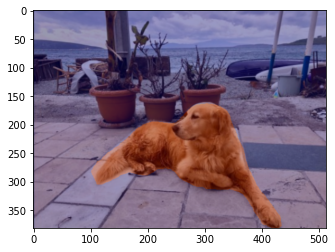

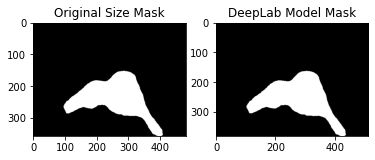

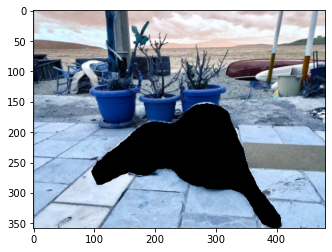

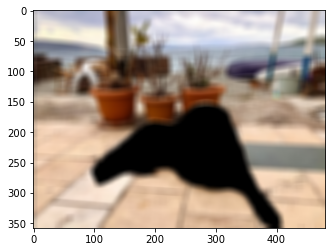

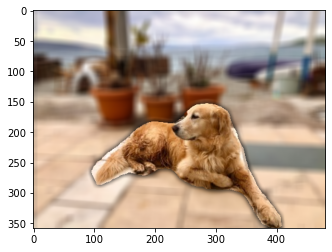

In [37]:
img_path = os.getenv('HOME')+'/aiffel/AIFFEL_LSG/lms/01-EXPLORATION/E14-portrait/imgs/dog3.jpg' 

portraitFn(img_path, "dog")

### 문제점 있는 이미지
- 뒤에 의자 검은 의자 가지 같이 처리됨

(640, 640, 3) (513, 513, 3) 15


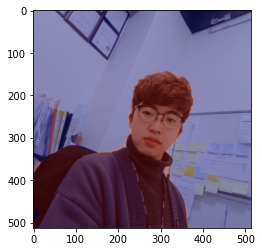

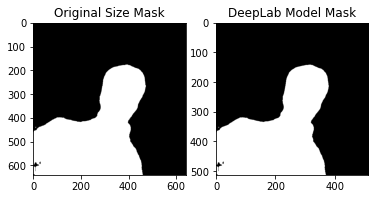

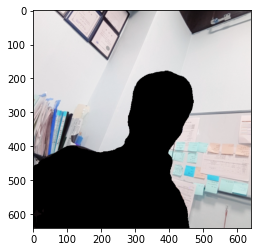

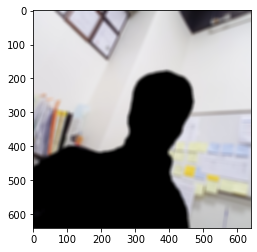

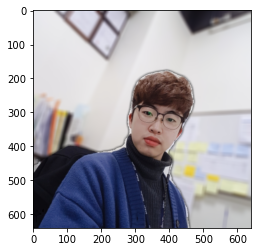

In [38]:
img_path = os.getenv('HOME')+'/aiffel/AIFFEL_LSG/lms/01-EXPLORATION/E14-portrait/imgs/lsg-03.jpg' 

portraitFn(img_path, "person")

### 개선안 제시